# Predicting Price Of Renting An Apartment In Lagos State.

The objective of this project is predicting the cost of renting an apartment in lagos state based on the area, number of bed rooms and number of toilets.
Data set for this project was gathered from https://tolet.ng, also scrapper for gathered the data can be found on my github here -> https://github.com/victorlenerd/toletngscrapper.

## Loading And Cleaning Data.

In [2]:
## Loading Data
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_json('./data.json')

%matplotlib inline

In [3]:
data.tail()

,area,no_bath,no_bed,no_toilets,price
9041,"Mafoluku road, Isolo, Mafoluku Oshodi Lagos",1,1,1,280000.0
9042,"Mafoluku road, Mafoluku Oshodi Lagos",1,1,1,280000.0
9043,,0,0,0,NaN
9044,,0,0,0,NaN
9045,,0,0,0,NaN


In [4]:
data.describe()

,no_bath,no_bed,no_toilets,price
count,9046.000000,9046.000000,9046.000000,7.846000e+03
mean,2.125138,2.170462,2.404378,3.302896e+06
std,1.588876,1.581791,1.889390,4.822354e+07
min,0.000000,0.000000,0.000000,1.000000e-02
25%,1.000000,1.000000,1.000000,5.000000e+05
50%,2.000000,2.000000,3.000000,1.000000e+06
75%,3.000000,3.000000,4.000000,2.875000e+06
max,10.000000,10.000000,10.000000,4.000000e+09


In [5]:
# The scrapper gathered some wrong values from dom elements that had the same property. It's best to drop them
data = data.dropna()

In [6]:
data.describe()

,no_bath,no_bed,no_toilets,price
count,7846.000000,7846.000000,7846.000000,7.846000e+03
mean,2.450166,2.502422,2.772113,3.302896e+06
std,1.454034,1.433170,1.759633,4.822354e+07
min,0.000000,0.000000,0.000000,1.000000e-02
25%,1.000000,1.000000,1.000000,5.000000e+05
50%,3.000000,3.000000,3.000000,1.000000e+06
75%,3.000000,3.000000,4.000000,2.875000e+06
max,10.000000,10.000000,10.000000,4.000000e+09


In [7]:
data.tail()

,area,no_bath,no_bed,no_toilets,price
9038,- Abule Egba Abule Egba Lagos,2,2,3,500000.0
9039,- Lekki Phase 1 Lekki Lagos,5,5,6,5500000.0
9040,"Awuse Estate, Opebi, Lagos Opebi Ikeja Lagos",5,5,6,2500000.0
9041,"Mafoluku road, Isolo, Mafoluku Oshodi Lagos",1,1,1,280000.0
9042,"Mafoluku road, Mafoluku Oshodi Lagos",1,1,1,280000.0


### Using areas.json to make area property more structured, by converting address to area.

In [8]:
## Loading Areas
areas = pd.read_json('./areas.json')

In [9]:
areas_dict = areas.to_dict()
areas_list = []

for key, value in areas_dict[0].items():
    areas_list.append(value)
    
print(areas_list)

['Abule Egba', 'Agege', 'Ajah', 'Ajaokuta', 'Alimosho', 'Amuwo Odofin', 'Apapa', 'Arepo', 'Badagry', 'Egbe Idimu', 'Egbeda', 'Ejigbo', 'Epe', 'Gbagada', 'Ibeju Lekki', 'Iju', 'Ikeja', 'Ikorodu', 'Ikotun Igando', 'Ikoyi', 'Ilaje', 'Ilupeju', 'Ipaja', 'Isolo', 'Ketu', 'Kosofe Ikosi', 'Lagos Island', 'Lekki', 'Maryland', 'Mushin', 'Ogba', 'Ogudu', 'Ojo', 'Ojodu', 'Ojota', 'Okota', 'Orile', 'Oshodi', 'Sangotedo', 'Shagari', 'Shomolu', 'Surulere', 'Victoria Island', 'Yaba']


In [10]:
def addressToArea(address):
    
    address = address.replace(',', '')
    address = address.replace('-', '')
    address = address.replace('/', ' ')
    
    for area in areas_list:
        if area in address:
            return area
    
    return address

In [11]:
data['area'] = data['area'].apply(addressToArea)
data.head()

,area,no_bath,no_bed,no_toilets,price
0,Ajah,3,3,4,1200000.0
1,Ikotun Igando,1,1,1,140000.0
2,Ikoyi,1,1,1,227100.0
3,Victoria Island,1,1,1,349850.0
4,Ikoyi,1,1,1,33900.0


In [12]:
# Remove entries with less than one bed rooms

data = data[data['no_bed'] > 1]

In [13]:
data.describe()

,no_bath,no_bed,no_toilets,price
count,5866.000000,5866.000000,5866.000000,5.866000e+03
mean,3.018411,3.125298,3.396693,3.491016e+06
std,1.193333,1.064734,1.494171,5.241682e+07
min,0.000000,2.000000,0.000000,1.000000e+00
25%,2.000000,2.000000,3.000000,7.000000e+05
50%,3.000000,3.000000,3.000000,1.500000e+06
75%,4.000000,4.000000,4.000000,3.300000e+06
max,10.000000,10.000000,10.000000,4.000000e+09


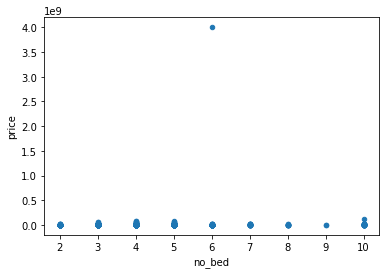

In [14]:
data.plot.scatter(x='no_bed', y='price')

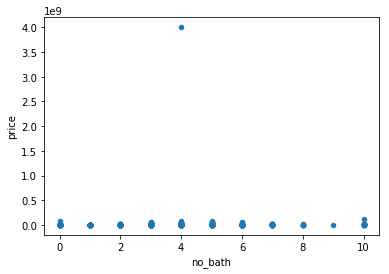

In [16]:
data.plot.scatter(x='no_bath', y='price')

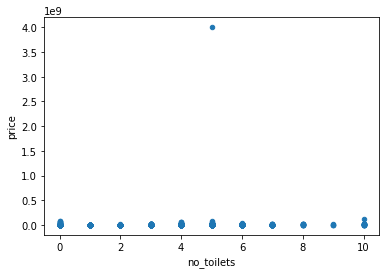

In [17]:
data.plot.scatter(x='no_toilets', y='price')